# Lecture 10 - A/B Testing

This notebook will show you how to perform A/B testing on Twitter data.

Below is the overview of this notebook.

<ol type = 1>
    <li> Favorite Count vs Keyword</li>
    <ol type = 1>
      <li> Z-test</li>
      <li> T-test</li>
      <li> Mann-Whitney U test</li>
      <li> Kolmogorov- Smirnov test</li>
      <li> Testing Multiple Hypotheses</li>
    </ol>
    <li> Comparing User Language</li>
    <ol type = 1>
      <li> Fisher Exact Test</li>
    </ol>
    <li> Engagement</li>
    <li> Tweet Time</li>
    <li> Correlation Coefficients</li>
    <ol type = 1>
         <li> Pearson Correlation Coefficient</li>
        <li> Spearman Correlation Coefficient</li>
    </ol>
</ol>

This notebook can be opened in Colab
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/zlisto/social_media_analytics/blob/main/Lecture10_ABTesting.ipynb)

Before starting, select "Runtime->Factory reset runtime" to start with your directories and environment in the base state.

If you want to save changes to the notebook, select "File->Save a copy in Drive" from the top menu in Colab.  This will save the notebook in your Google Drive.




# Clones, installs, and imports


## Clone GitHub Repository
This will clone the repository to your machine.  This includes the code and data files.  Then change into the directory of the repository.

In [2]:
!git clone https://github.com/zlisto/social_media_analytics

import os
os.chdir("social_media_analytics")

Cloning into 'social_media_analytics'...
remote: Enumerating objects: 2623, done.
remote: Counting objects: 100% (2623/2623), done.
remote: Compressing objects: 100% (2220/2220), done.
remote: Total 2623 (delta 411), reused 2609 (delta 398), pack-reused 0
Receiving objects: 100% (2623/2623), 173.28 MiB | 25.98 MiB/s, done.
Resolving deltas: 100% (411/411), done.
Updating files: 100% (1969/1969), done.


## Import Packages



In [1]:
from datetime import datetime, timedelta
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from statsmodels.stats.weightstats import ztest
from statsmodels.stats.multitest import multipletests


#display settings for figures
pd.set_option("display.max_colwidth", None)
plt.rcParams.update({'axes.labelsize': 16,
                     'xtick.labelsize': 14,
                     'ytick.labelsize': 14})
plt.rcParams['figure.figsize'] = [8, 6]

# Data Processing

## Load data

The data is in `"data/bidenharris.csv.csv"`.  This contains tweets for several prominent Twitter users.

In [2]:
fname = "data/bidenharris.csv"

df_all = pd.read_csv(fname)
ntweets = len(df_all)
print(f"dataframe has {ntweets} tweets")
df_all.screen_name.unique()

dataframe has 2018 tweets


array(['JoeBiden', 'KamalaHarris'], dtype=object)

## Add keyword indicator column

We will define a list of keywords.  Then we will add a column to the dataframe called `f"keyword_{keyword}"` that tells us if the tweet contains the keyword.  

In [5]:
# prompt: for each word in a list of keywords ['congress','love', 'hate'] add a column to df_all this called f"keyword_{keyword}" which is True if text column has the keyword, case insensitive


keywords = ['love','hate', 'jill','trump','mad','happy']

for keyword in keywords:
  col = f'keyword_{keyword}'
  regex_pattern = fr'\b{keyword}\b'
  df_all[col] = df_all.text.str.contains(regex_pattern, case=False, regex=True)
  ntweets = len(df_all[df_all[col]==True])
  print(f"{keyword}: {ntweets} tweets")

df_all.sample(n=2)

love: 71 tweets
hate: 26 tweets
jill: 41 tweets
trump: 61 tweets
mad: 96 tweets
happy: 44 tweets


,tweet_id,text,language,type,bookmark_count,favorite_count,retweet_count,reply_count,view_count,created_at,...,urls,media_type,media_urls,screen_name,keyword_love,keyword_hate,keyword_jill,keyword_trump,keyword_mad,keyword_happy
1214,1740148347539767457,"In 2023, I had the opportunity to meet so many inspiring small business owners like Tracy in Georgia.\n \nAs we move into the new year, @POTUS and I are proud of the investments we have made to push our nation toward the strongest three years on record for small business creation. https://t.co/VF9xm8bZEi",en,Retweet,68,8153,1689,2389,513524.0,2023-12-27 18:11:11,...,NaN,video,https://video.twimg.com/amplify_video/1740148196578365440/vid/avc1/1080x1920/MX713-jXKY83d5U3.mp4?tag=16,KamalaHarris,False,False,False,False,True,False
1245,1736419738383781980,It was so great to see Jeremiah again after meeting him on the @JHudShow last spring.\n\nI cannot wait to share our interview next week — Jeremiah had a lot of questions for @SecondGentleman! https://t.co/c4CfV7AHfl,en,Retweet,41,6475,944,1255,497802.0,2023-12-17 11:15:01,...,NaN,photo,https://pbs.twimg.com/media/GBkAjHWXMAAmptS.jpg,KamalaHarris,False,False,False,False,False,False


# Favorite Count vs. Keyword

We will look at the tweets of a single user and compare favorite counts versus keywords.

## Create Single User Dataframe

Make a dataframe `df_u` that is the tweets of a user in `df_all` with `screen_name` of your choice.  Make sure `df_u` is a `copy()` of `df_all`

In [6]:
screen_name = 'JoeBiden'
df_u = df_all[df_all.screen_name==screen_name].copy()

## Plot like count vs keyword


We will plot the favorite count vs. keyword for each keyword in the list `keywords`.  We use the `barplot` function and set the confidence intervals with the `ci` parameter.

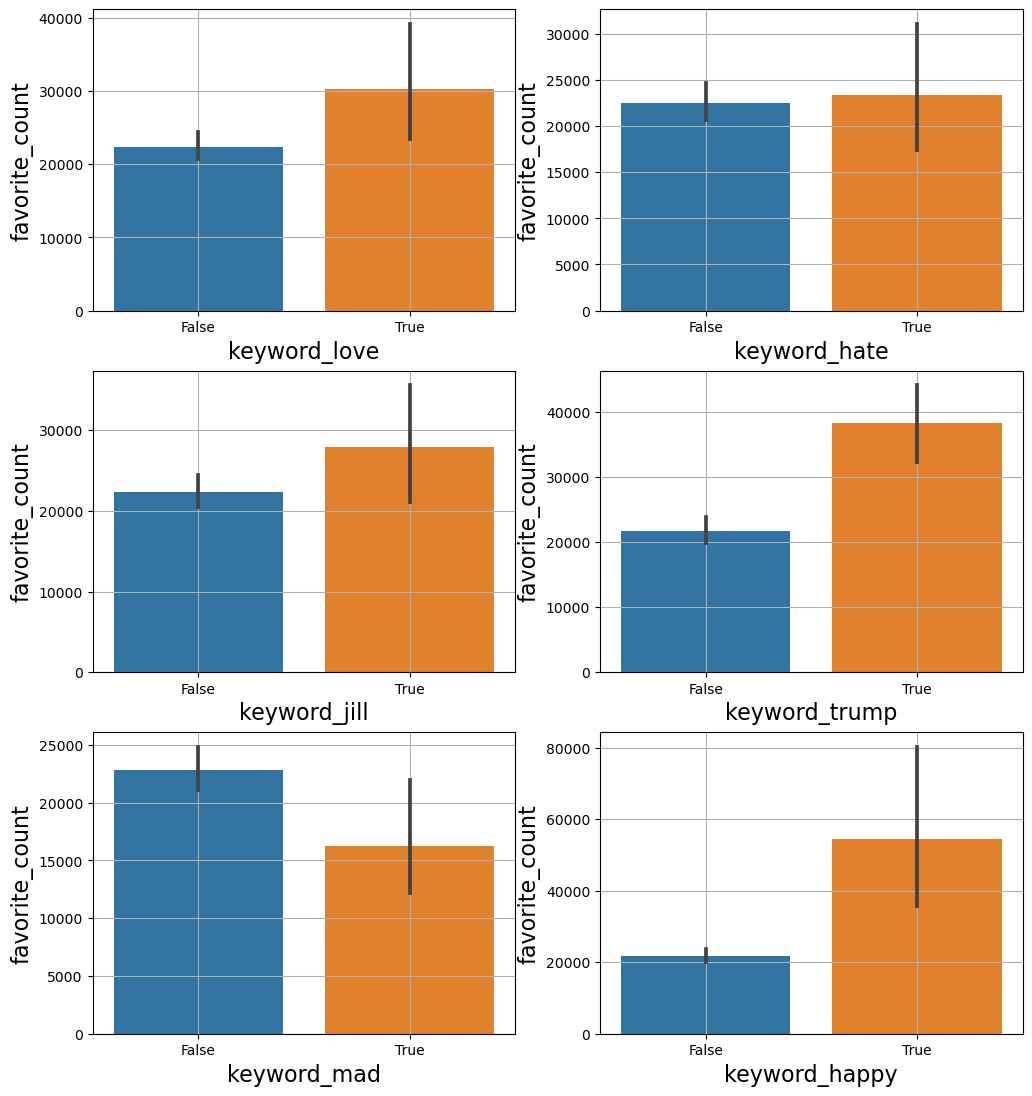

In [8]:
col = 'favorite_count'
fig = plt.figure(figsize = (12,18))
nrows = int(len(keywords)/2) + 1
c=0
for keyword in keywords:
    c+=1
    plt.subplot(nrows,2,c)
    sns.barplot(data = df_u,
                x= f"keyword_{keyword}",
                y = col,
                errorbar=('ci', 95))
    plt.xticks(fontsize = 10)
    plt.yticks(fontsize = 10)
    plt.grid()
plt.show()

## Create Data for Statistical Tests

We will created arrays `X0` and `X1` that are the retweet counts without  and with a keyword.

In [9]:
# prompt: create arrays X0 and X1 that are like_count in df_u where keyword_congress is False and True

keyword = "trump"

ind = df_u[f"keyword_{keyword}"]==True
col = 'favorite_count'
X0 = df_u.loc[~ind,col]
X1 = df_u.loc[ind,col]
n0 = len(X0)
n1 = len(X1)

mu0 = np.mean(X0)
mu1 = np.mean(X1)

print(f"Tweets of {screen_name}")
print(f"Contains {keyword}\tNumber of tweets\tMean {col}")
print(f"False\t\t{n0}\t\t\t{mu0:.1f}")
print(f"True\t\t{n1}\t\t\t{mu1:.1f}")

Tweets of JoeBiden
Contains trump	Number of tweets	Mean favorite_count
False		953			21690.1
True		50			38278.3


## Statistical Tests

We will conduct a variety of statistical tests on `X0` and `X1` to see if they are different.  The statistical tests we use have similar structure.  They each return the test statistic and the p-value.  They let us specify what alternative hypothesis we are looking for using the  `alternative` parameter. Its value can be set to

1. `'two-sided'` = means are different

2. `'less'` = mean of first argument is less than second argument

3. `'greater'` = mean of first argument is greater than second argument

We can set our significance level `alpha` to determine if we deem the test significant or not.  Significant means `pval<=alpha`.

### Z-test

We will apply a z-test to see if the mean favorite count is different for tweets with and without the keyword.  We apply the `ztest` function to `X0` and `X1`.  We set `value=0` which means under the null hypothesis the means are equal.  The test returns the z-statistic `zstat` and the p-value `pval`.  The z-test is appropriate when you know the variance (which is usually never).



In [11]:
# prompt: X0 and X1 are two arrays of numeric samples.  conduct a ztest to see if they ahve differnet means
alpha = 0.01  #significance level

(zstat, pval) = ztest(X0, X1,
                      value=0,
                      alternative='two-sided',
                      usevar = 'unequal')


print(f"Z-test")
print(f"{keyword}: z-stat = {zstat:.3f} ({pval:.3e})\n")
if pval <=alpha:
  print(f"Significant at {alpha*100:.0f}% level")
else:
  print(f"Not significant at {alpha*100:.0f}% level")

Z-test
trump: z-stat = -3.797 (1.465e-04)

Significant at 1% level


### T-test

We can apply the t-test to compare the mean favorite counts.  The t-test is appropriate when the variance is unknown.  We use the function `ttest_ind` and set `equal_var=False`.

In [12]:
alpha = 0.01  #significance level

(tstat, pval) =stats.ttest_ind(X0,X1,
                               equal_var = False,
                               nan_policy = 'omit',
                               alternative = 'two-sided')

print('T-test')
print(f"{keyword}: t-stat = {tstat:.3f} ({pval:.3e})\n")
if pval <=alpha:
  print(f"Significant at {alpha*100:.0f}% level")
else:
  print(f"Not significant at {alpha*100:.0f}% level")

T-test
trump: t-stat = -4.838 (1.000e-05)

Significant at 1% level


### Mann-Whitney U test

The Mann-Whitney U test is a non-parametric test that deals with the probability `X0>X1`.  We use the `mannwhitneyu` function.

In [13]:
alpha = 0.01  #significance level

ustat, pval = stats.mannwhitneyu(X0, X1,
                                nan_policy = 'omit',
                                alternative = 'two-sided')

print('Mann Whitney U test')
print(f"{keyword}: U-stat = {ustat:.3f} ({pval:.3e})\n")
if pval <=alpha:
  print(f"Significant at {alpha*100:.0f}% level")
else:
  print(f"Not significant at {alpha*100:.0f}% level")

Mann Whitney U test
trump: U-stat = 10378.000 (1.646e-11)

Significant at 1% level


### Kolmogorov-Smirnov test

The Kolmogorov-Smirnov test is a non-parametric test with the null hypothesis that the cumulative distribution functions of the two groups are equal.  We use the `ks_2samp` function.


In [14]:
alpha = 0.01  #significance level

ksstat, pval = stats.ks_2samp(X0, X1,
                              alternative='two-sided')

print('Kolmogorov-Smirnov test')
print(f"{keyword}: KS-stat = {ksstat:.3f} ({pval:.3e})\n")
if pval <=alpha:
  print(f"Significant at {alpha*100:.0f}% level")
else:
  print(f"Not significant at {alpha*100:.0f}% level")

Kolmogorov-Smirnov test
trump: KS-stat = 0.574 (2.956e-15)

Significant at 1% level


## Testing Multiple Hypotheses

If we test all the keywords to see which ones increase the mean favorite count, we need to correct the p-values to account for the multiple hypotheses.  We first choose a significance level `alpha`, which is either the family-wise error rate (FWER) or the false discovery rate (FDR).  Then we calculate the p-value of a t-test for each keyword and save these p-values in a list `pvals`.  Finally, we apply the `multipletests` function to `pvals` and set `method` to our method of choice.  We save the results in a dataframe `df_p` so we can read the results easily.

The `method` options include

1. `'bonferroni'` = Bonferroni method (FWER)

2. `'sidak'` = Sidak method (FWER)

3. `'holm'` = Holm-Bonferroni method (FWER)

4. `'benjamini-hochberg'` or `'fdr_bh'` = Benjamini-Hochberg method (FDR)

### Calculate P-Values

First we need to calculate the p-values for each keyword and save the result to a list `pvals`.

In [15]:
pvals = []
col = 'favorite_count'
for keyword in keywords:
  ind = df_u[f"keyword_{keyword}"]==True
  X0 = df_u.loc[~ind,col]
  X1 = df_u.loc[ind,col]
  (tstat, pval) =stats.ttest_ind(X0,X1, equal_var = False)
  pvals.append(pval)
  print(f"{keyword}: t-stat = {tstat:.3f} ({pval:.3e})")



love: t-stat = -1.903 (6.569e-02)
hate: t-stat = -0.245 (8.087e-01)
jill: t-stat = -1.420 (1.633e-01)
trump: t-stat = -4.838 (1.000e-05)
mad: t-stat = 2.332 (2.287e-02)
happy: t-stat = -2.719 (1.313e-02)


### Apply `multipletests`

Set `method` to your method of choice.

In [16]:
alpha = 0.01  #significance level
method = 'holm'  #multiple testing method

rejects,pvals_corrected,_,_ = multipletests(pvals,
                                            alpha=alpha,
                                            method=method,
                                            is_sorted=False,
                                            returnsorted=False)
df_p = pd.DataFrame({'keyword':keywords,
                     'reject_H0':rejects,
                     'pval':pvals})
print(f"{method} method t-test")
df_p

holm method t-test


,keyword,reject_H0,pval
0,love,False,0.065691
1,hate,False,0.808687
2,jill,False,0.163285
3,trump,True,0.000010
4,mad,False,0.022871
5,happy,False,0.013130


# Comparing Users Language

We will look at two users and see if they use a given keyword with the same frequency.

## Contingency table

We select two users with screen names given by the variables `w0` and `w1` and we select a keyword `keyword`.  Then we calculate the contingency table for this data using the `pd.crosstab` function, where we give it the `screen_name` column and a column that is `True` or `False` if `text` contains `keyword`..  The table has the values `a`,`b`,`c`,`d` which indicate the number of tweets in each category as follows:

|Has keyword |User 0 | User 1|
|-|--------|------|
|True | a| b|
|False| c|d|

We store the table as a list of lists in `table`.

In [22]:
w0 = 'JoeBiden'
w1= 'KamalaHarris'
keyword ='vote'  #you can pick any keyword you like, not just the ones in the keywords list

regex_pattern = fr'\b{keyword}\b'
df2 = df_all[df_all.screen_name.isin([w0,w1])]  #df1 only has tweets from the two users you want to compare
contingency_table = pd.crosstab(df2['screen_name'],
                                df2['text'].str.contains(regex_pattern, case=False, regex=True))

print(f"Contingency Table for {keyword}")
contingency_table

Contingency Table for vote


text,False,True
screen_name,,
JoeBiden,984,19
KamalaHarris,966,49


## Fisher Exact Test

We apply the Fisher exact test to the contingency table to see if the frequencies are different for the two users.  This is done with the `fisher_exact` function.

In [23]:
alpha = 0.01  #significance level

# Perform Fisher exact test
oddsratio, pval = stats.fisher_exact(contingency_table)


print('Fisher exact test')
print(f"{keyword}: odds ratio = {oddsratio:.3f} ({pval:.3e})\n")
if pval <=alpha:
  print("Significant at 1% level")
else:
  print("Not significant at 1% level")

Fisher exact test
vote: odds ratio = 2.627 (2.890e-04)

Significant at 1% level


# Engagement

Define `"engagement"` of a tweet as its `"favorite_count"` divided by its `"views"`.  This measures what fraction of a tweet's viewers like the tweet.  We will compare the engagement for a pair of users.

In [24]:
df_all = df_all[~df_all.view_count.isna()].copy()
df_all['engagement'] = df_all.favorite_count/(df_all.view_count)


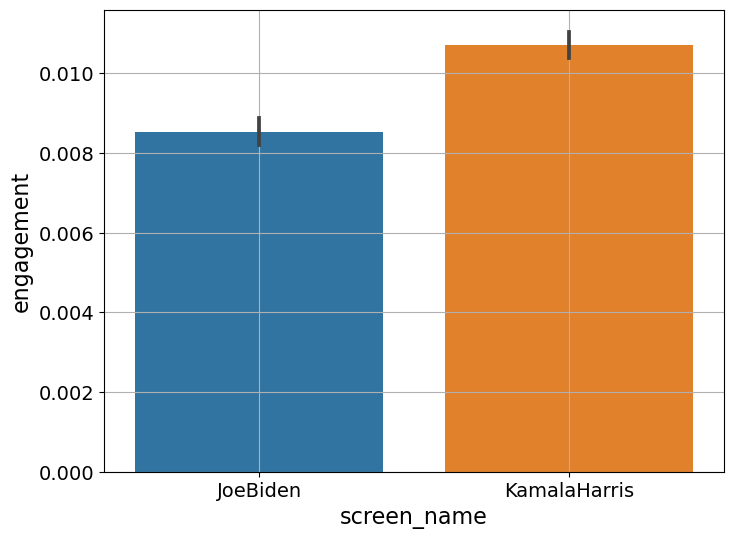

In [25]:
sns.barplot(data = df_all,
            x = 'screen_name',
            y = 'engagement',
            )
plt.grid()
plt.show()

## T-test for engagement

In [26]:
alpha = 0.01  #significance level
col = 'engagement'
w0, w1 = df_all.screen_name.unique()

print(f"w0 = {w0}\nw1 = {w1}")

X0 = df_all.loc[df_all.screen_name==w0, col].values
X1 = df_all.loc[df_all.screen_name==w1,col].values

mu0 = np.mean(X0)
mu1 = np.mean(X1)

(tstat, pval) =stats.ttest_ind(X0,X1,
                               equal_var = False,
                               nan_policy = 'omit',
                               alternative = 'two-sided')
print(f"Screen name\tMean engagement")
print(f"{w0}\t{mu0:.2e}")
print(f"{w1}\t{mu1:.2e}")

print(f"{w0} vs {w1}: t-stat = {tstat:.3f} ({pval:.4e})\n")
if pval <=alpha:
  print(f"Significant at {alpha*100:.0f}% level")
else:
  print(f"Not significant at {alpha*100:.0f}% level")

w0 = JoeBiden
w1 = KamalaHarris
Screen name	Mean engagement
JoeBiden	8.54e-03
KamalaHarris	1.07e-02
JoeBiden vs KamalaHarris: t-stat = -9.436 (1.0346e-20)

Significant at 1% level


# Tweet Time

We will study how the timing of a tweet is related to the like counts and sentiment for a user.  The user is former President Donald Trump.  The data is in file `"data/trump_tweets_sentiment.csv"` and was obtained from a Kaggle challenge: https://www.kaggle.com/datasets/codebreaker619/donald-trump-tweets-dataset.  The sentiment was calculated using the Huggin Face model at https://huggingface.co/nlptown/bert-base-multilingual-uncased-sentiment.

## Load data

In [27]:
screen_name = 'realDonaldTrump'
df_trump = pd.read_csv("data/trump_tweets_sentiment.csv")
df_trump.head(1)

,Unnamed: 0,id,text,is_retweet,is_deleted,device,favorites,retweets,datetime,is_flagged,date,sentiment
0,0,9.845497e+16,Republicans and Democrats have both created our economic problems.,False,False,TweetDeck,49,255,2011-08-02T18:07:48Z,False,2011-08-02,0.258977


## Add day of week and hour columns

We will add columns indicating the hour and day of the week for each tweet.

In [28]:
# prompt: We will add columns indicating the hour and day of the week for each tweet from the created_at column

format = "%Y-%m-%d %H:%M:%S"

df_trump['datetime'] = pd.to_datetime(df_trump['datetime']
                                      ,format=format)
df_trump['datetime_est'] = df_trump['datetime'].dt.tz_convert('America/New_York')
df_trump['day'] = df_trump.datetime_est.dt.day_name()   #get the day of the tweet
df_trump['hour'] = df_trump.datetime_est.dt.hour   #get the hour of the tweet

df_trump = df_trump.sort_values(by = 'datetime')
df_trump.head(n=1)

,Unnamed: 0,id,text,is_retweet,is_deleted,device,favorites,retweets,datetime,is_flagged,date,sentiment,datetime_est,day,hour
7041,13325,1.698309e+09,Be sure to tune in and watch Donald Trump on Late Night with David Letterman as he presents the Top Ten List tonight!,False,False,Twitter Web Client,939,519,2009-05-04 18:54:25+00:00,False,2009-05-04,0.75937,2009-05-04 14:54:25-04:00,Monday,14


## Plot Favorites vs. Hour

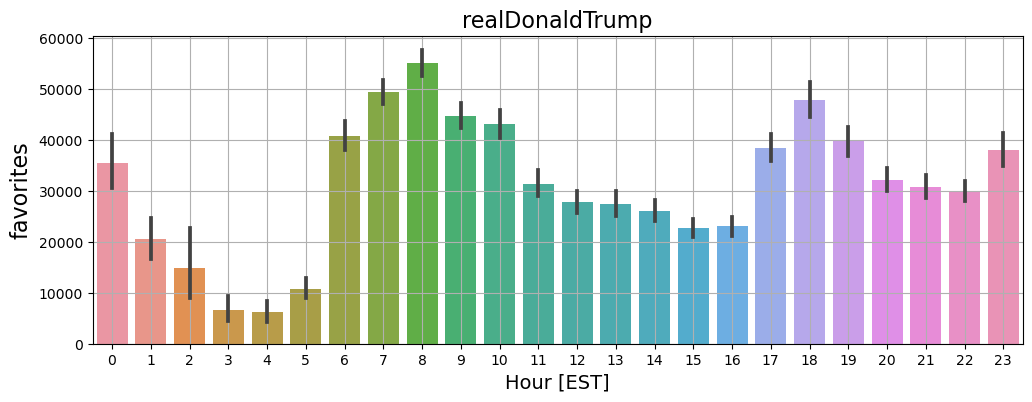

In [30]:
fig = plt.figure(figsize =(12,4))
sns.barplot(data =df_trump , x = 'hour',
            y = 'favorites',
            errorbar=('ci', 95))
plt.xlabel("Hour [EST]", fontsize = 14)
plt.title(f"{screen_name}", fontsize = 16)
plt.xticks(fontsize = 10)
plt.yticks(fontsize = 10)
plt.grid()
plt.show()

## T-test for Hours

We select two hours and compare the like counts using a t-test.

In [31]:
alpha = 0.01  #significance level
h0 = 8  #first hour to check
h1 = 23  #second hour to check
col = 'favorites'  #metric we are comparing


X0 = df_trump.loc[df_trump.hour==h0,col]
X1 = df_trump.loc[df_trump.hour==h1,col]
mu0 = np.mean(X0)
mu1 = np.mean(X1)
(tstat, pval) =stats.ttest_ind(X0,X1, equal_var = False)

print(f"Hour [EST]\tMean retweet count")
print(f"{h0}\t\t{mu0:.2f}")
print(f"{h1}\t\t{mu1:.2f}")
print(f"{h0} vs {h1}: t-stat = {tstat:.3f} ({pval:.4e})\n")
if pval <=alpha:
  print(f"Significant at {alpha*100:.0f}% level")
else:
  print(f"Not significant at {alpha*100:.0f}% level")

Hour [EST]	Mean retweet count
8		54982.74
23		38033.58
8 vs 23: t-stat = 7.894 (3.8969e-15)

Significant at 1% level


## Plot Favorites vs. Day

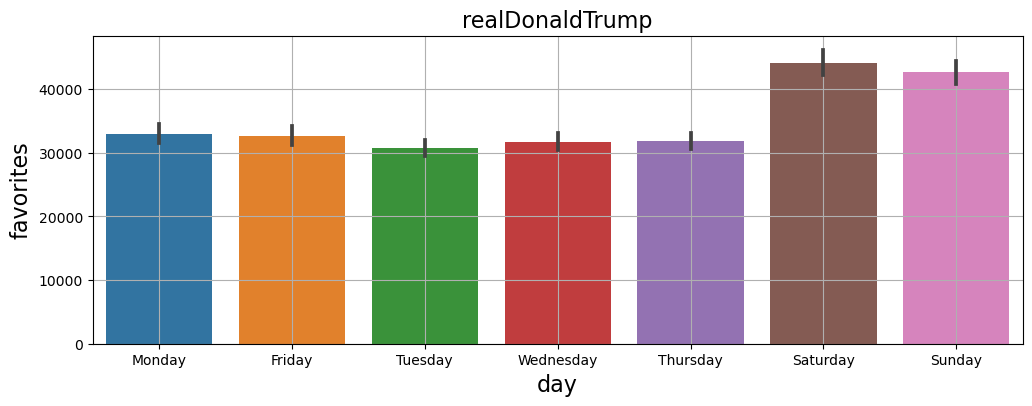

In [32]:
fig = plt.figure(figsize =(12,4))
sns.barplot(data =df_trump ,
            x = 'day',
            y = 'favorites',
            errorbar=('ci', 95))
plt.title(f"{screen_name}", fontsize = 16)
plt.xticks(fontsize = 10)
plt.yticks(fontsize = 10)
plt.grid()
plt.show()

## T-test for Days

In [33]:
alpha = 0.01  #significance level
h0 = 'Monday'  #first day to check
h1 = 'Saturday'  #second day to check
col = 'favorites'  #metric we are comparing


X0 = df_trump.loc[df_trump.day==h0,col]
X1 = df_trump.loc[df_trump.day==h1,col]

mu0 = np.mean(X0)
mu1 = np.mean(X1)
(tstat, pval) =stats.ttest_ind(X0,X1, equal_var = False)

print(f"Day\tMean {col} count")
print(f"{h0}\t{mu0:,.0f}")
print(f"{h1}\t{mu1:,.0f}")
print(f"{h0} vs {h1}: t-stat = {tstat:.3f} ({pval:.4e})\n")
if pval <=alpha:
  print(f"Significant at {alpha*100:.0f}% level")
else:
  print(f"Not significant at {alpha*100:.0f}% level")

Day	Mean favorites count
Monday	32,894
Saturday	44,092
Monday vs Saturday: t-stat = -9.334 (1.2383e-20)

Significant at 1% level


## T-test for day vs night

We can choose a range of hours to compare daytime and nighttime tweets' like counts.

In [34]:
#create daytime column in df_trump
#daytime
ind_day = (6<=df_trump.hour) & (df_trump.hour<=19)
df_trump['daytime'] = ind_day

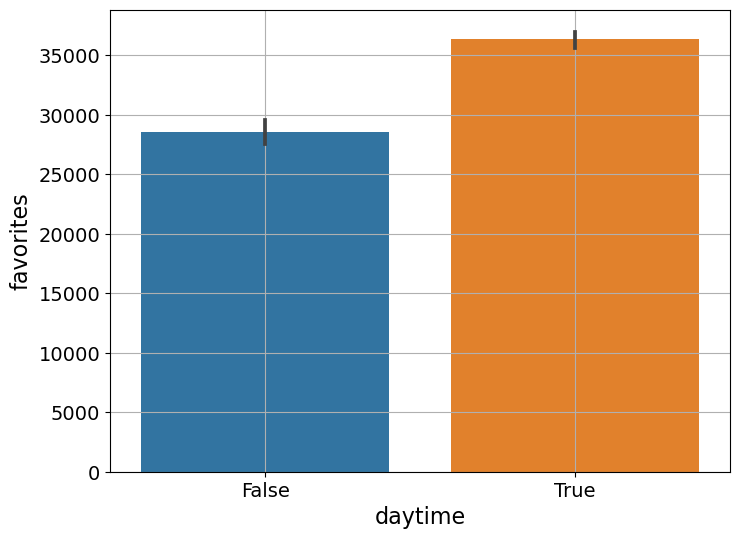

In [35]:
sns.barplot(data = df_trump,
            x = 'daytime',
            y = col)
plt.grid()
plt.show()

In [36]:
col = 'favorites'

#create data for t-test
X0 = df_trump.loc[df_trump.daytime==True,col]
X1 = df_trump.loc[df_trump.daytime==False,col]

mu0 = np.mean(X0)
mu1 = np.mean(X1)
(tstat, pval) =stats.ttest_ind(X0,X1, equal_var = False)

print(f"Time\tMean {col}")
print(f"Day\t{mu0:.2f}")
print(f"Night\t{mu1:.2f}")
print(f"Day vs Night: t-stat = {tstat:.3f} ({pval:.4e})\n")
alpha = 0.01  #significance level
if pval <=alpha:
  print("Significant at 1% level")
else:
  print("Not significant at 1% level")



Time	Mean favorites
Day	36343.20
Night	28559.62
Day vs Night: t-stat = 12.330 (8.0627e-35)

Significant at 1% level


## Sentiment: Day vs Night

Lets look at the tweet sentiment of day versus night.  

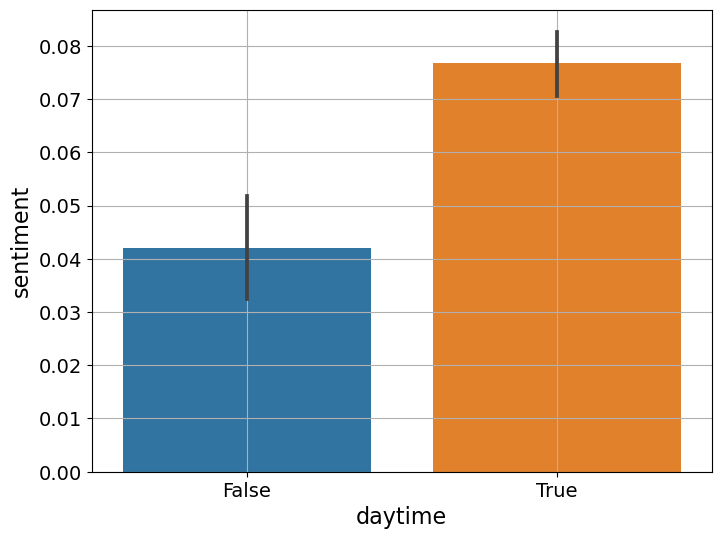

In [37]:
sns.barplot(data = df_trump,
            x = 'daytime',
            y = 'sentiment')
plt.grid()
plt.show()

In [39]:
col = 'sentiment'

#create data for t-test
X0 = df_trump.loc[df_trump.daytime==True,col]
X1 = df_trump.loc[df_trump.daytime==False,col]


mu0 = np.mean(X0)
mu1 = np.mean(X1)
(tstat, pval) =stats.ttest_ind(X0,X1, equal_var = False)

print(f"{col} Day vs Night: t-stat = {tstat:.3f} ({pval:.4e})\n")
alpha = 0.01  #significance level
if pval <=alpha:
  print("Significant at 1% level")
else:
  print("Not significant at 1% level")


sentiment Day vs Night: t-stat = 5.915 (3.3612e-09)

Significant at 1% level


# Favorites vs Sentiment

We can plot the sentiment (put into discrete bins) versus favorite count.

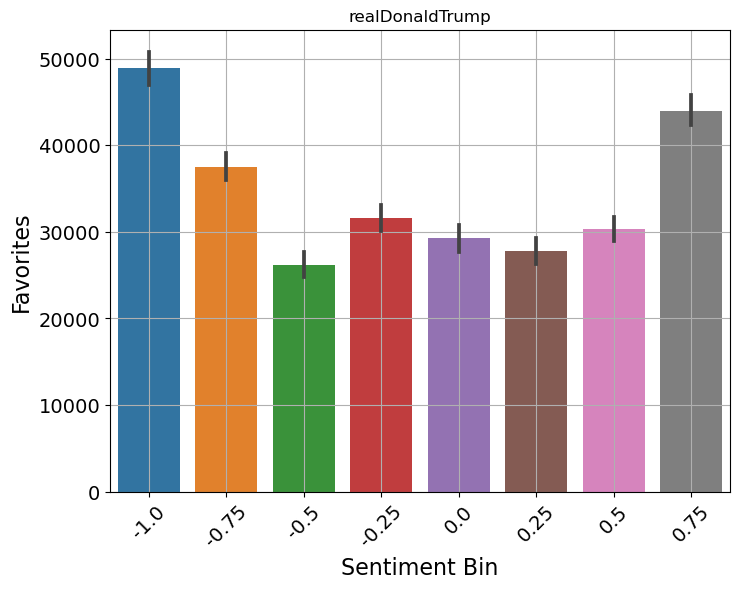

In [40]:
# Define bins from -1 to 1 with spacing of 0.5
bins = np.arange(-1,1.25,0.25)

# Use pd.cut() to bin the sentiment values
df_trump['sentiment_bin'] = pd.cut(df_trump['sentiment'], bins, labels=False)

# Map the numeric bins to more readable labels if desired (optional)
bin_labels = [str(x) for x in bins[:-1]]
df_trump['sentiment_bin_labels'] = pd.cut(df_trump['sentiment'],
                                          bins,
                                          labels=bin_labels)

# Plotting the boxplot
sns.barplot(data=df_trump, x='sentiment_bin_labels', y='favorites')
plt.xticks(rotation=45)  # Rotate x labels for better readability
plt.title(f'{screen_name}')
plt.xlabel('Sentiment Bin')
plt.ylabel('Favorites')

plt.grid()
plt.show()

# Correlation Coefficient

We will look at the correlation of  sentiment with favorites count for a single user.

## Pearson Correlation Coefficient

 We apply the `pearsonr` function to the like_count and sentiment columns of the dataframe.  The function returns the Pearson correlation coefficient `cc` and the p-value `pval`.

In [41]:
alpha = 0.01
col1 = 'sentiment'  #first column for which you want correlation
col2 = 'favorites'  #second column for which you want correlation
cc,pval = stats.pearsonr(df_trump[col1], df_trump[col2])

print(f"Pearson corr of {col1} and {col2} = {cc:.3f} ({pval:.3e})")
if pval <=alpha:
  print(f"Significant at {alpha*100:.0f}% level")
else:
  print(f"Not significant at {alpha*100:.0f}% level")

Pearson corr of sentiment and favorites = -0.009 (4.267e-02)
Not significant at 1% level


## Spearman Rank Correlation Coefficient

Spearman's rank correlation coefficient is a non-parametric correlation coefficient that is less susceptible to outliers because it considers the rank of the data, not its values.

In [42]:
alpha = 0.01
col1 = 'sentiment'  #first column for which you want correlation
col2 = 'favorites'  #second column for which you want correlation
cc,pval = stats.spearmanr(df_trump[col1], df_trump[col2])

print(f"Spearman corr of {col1} and {col2} = {cc:.3f} ({pval:.3e})")
if pval <=alpha:
  print(f"Significant at {alpha*100:.0f}% level")
else:
  print(f"Not significant at {alpha*100:.0f}% level")

Spearman corr of sentiment and favorites = -0.057 (2.246e-34)
Significant at 1% level


## Absolute Sentiment vs Favorite Count

Lets look at the absolute value of the sentiment and interaction count.

In [43]:
df_trump['sentiment_abs'] = df_trump['sentiment'].abs()


In [44]:
alpha = 0.01
col1 = 'sentiment_abs'  #first column for which you want correlation
col2 = 'favorites'  #second column for which you want correlation
cc,pval = stats.spearmanr(df_trump[col1], df_trump[col2])

print(f"Spearman corr of {col1} and {col2} = {cc:.3f} ({pval:.3e})")
if pval <=alpha:
  print(f"Significant at {alpha*100:.0f}% level")
else:
  print(f"Not significant at {alpha*100:.0f}% level")

Spearman corr of sentiment_abs and favorites = 0.110 (2.368e-125)
Significant at 1% level
